In [ ]:
%load_ext autoreload
%autoreload 2

In [131]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import load_data as ld
from rawDataHandler import RawDataHandler, NodeDfStore

In [132]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20,
                     'axes.labelsize': 20,
                     'legend.fontsize': 20})
plt.rc('font',**{'family':'serif','serif':['Times']})
color1= '#94b4a4'
color2='#deebf7'
color3='#fff7bc'

In [133]:
#def parse_dash_logs(dash_log, mpeg_log, param_settings):
    # Read the logs

    # This is done so that the entry matches the time when it was requested 
    # the ABR computes the bitrate for the next segment as soon as the 
    # previous segment is received, and provides the time at which the next segment
    # should be requested. We are adding this time to the timestamp of when 
    # the bitrate decision is printed 

    


In [134]:
raw_data_dir = '../data/raw_data/dataset7_35Mbps_max_brate_withCa/'
#subfolders = ['run1']
subfolders = os.listdir(raw_data_dir)
print(subfolders)

['run17', 'run18', 'run12', 'run10', 'run11', 'run3', 'run21', 'run22', 'run13', 'run1', 'run5', 'run24', 'run9', 'run6', 'run2', 'run4', 'run23', 'run20', 'run14', 'run25', 'run7', 'run19', 'run16']


In [ ]:
# These are the metrics I want to aggregate over al lnodes and runs 
total_num_segments = []
total_time_seconds = []
time_between_requests = []
total_changes_in_brate = []
time_to_download_segment = [] 
thput_over_segments = []

for run in subfolders:
    print(run)
    read_path = raw_data_dir + run + "/"
    dash_log = read_path + "dash_client_log.txt"
    mpeg_log = read_path + "mpeg_player_log.txt"
    param_settings = read_path + "parameter_settings.txt"
    
    # Read the logs
    df_Dashlog = ld.load_dash_client_log(dash_log)
    #print(df_Dashlog.columns)
    df_Dashlog['Time'] = round(df_Dashlog['Time'] / 1e6, 3)
    df_Dashlog['Time'] = df_Dashlog['Time'] + df_Dashlog['delayToNxtReq_s']
    gp_Dashlog = df_Dashlog.groupby(['Node'])
    df_MpegLog = ld.load_std_log(mpeg_log, timeHead="tstamp_us")
    df_MpegLog['Time'] = round(df_MpegLog['Time'] / 1e6, 3)
    gp_MpegBuffer = df_MpegLog.groupby(['Node'])

    # Iterate over each node, It should not matter whether 
    # I get the node list from dash log or mpeg log  
    for nd in gp_Dashlog.groups.keys():
        df_node_raw_dash = pd.DataFrame(gp_Dashlog.get_group(nd))
        df_node_raw_mpeg = pd.DataFrame(gp_MpegBuffer.get_group(nd))
        df_node_raw_dash = df_node_raw_dash.sort_values(['Time'])
        # start counting what I want to count
        # we will have one sample per node in a run 
        # Single numbers 
        total_num_segments.append(df_node_raw_dash.shape[0])
        total_time_seconds.append(df_node_raw_dash['Time'].iloc[-1] - 
                                                       df_node_raw_dash['Time'].iloc[0])
        total_changes_in_brate.append((df_node_raw_dash['newBitRate_bps'] != 
                         df_node_raw_dash['newBitRate_bps'].shift()).sum(axis=0)) 
        
        # lists 
        time_between_requests.extend((df_node_raw_dash['Time'] - 
                                      df_node_raw_dash['Time'].shift()).dropna().tolist())
        time_to_download_segment.extend( ((df_node_raw_dash['oldBitRate_bps']*8 / 
                                         df_node_raw_dash['thputOverLastSeg_bps']).tolist())*8 )
        thput_over_segments.extend(df_node_raw_dash['thputOverLastSeg_bps']/1e6)
        
    

    #parse_dash_logs(dash_log, mpeg_log, param_settings)
    #proc_data.append([dash_log, mpeg_log, param_settings])
    #mp = Pool(processes=10)
    #mp.starmap(parse_dash_logs, proc_data)

In [136]:
# print the required numbers

# ABR changes per unit time 
print('ABR changes per second')
print(sum(total_changes_in_brate) / sum (total_time_seconds))

print('Average time in seconds between ABR change')
print(sum (total_time_seconds) / sum(total_changes_in_brate))

# ABR changes per unit segment or the fraction of segments that have been changes 
print('Fraction of segments sent that were ABR changes')
print(sum(total_changes_in_brate) / sum(total_num_segments))

ABR changes per second
0.04216777207271013
Average time in seconds between ABR change
23.71479333258808
Fraction of segments sent that were ABR changes
0.34075333368751


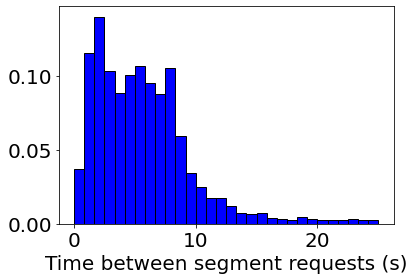

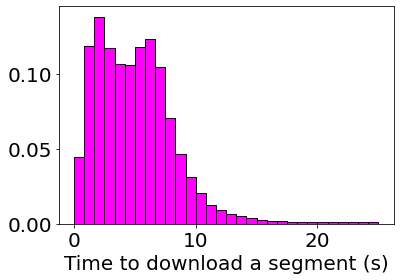

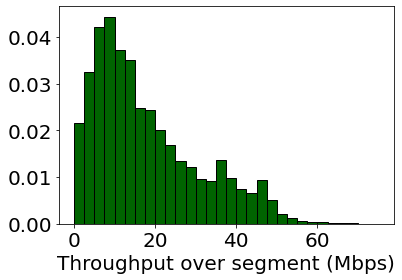

In [140]:
# histograms 
n_bins = 30
plt.hist(time_between_requests, bins=n_bins, facecolor='blue', 
         edgecolor ='k', range=(0, 25), density=True)
plt.xlabel('Time between segment requests (s)')
plt.show()

n_bins = 30
plt.hist(time_to_download_segment, bins=n_bins, facecolor='magenta', 
         edgecolor ='k', range=(0, 25), density=True)
plt.xlabel('Time to download a segment (s)')
plt.show()

n_bins = 30
plt.hist(thput_over_segments, bins=n_bins, facecolor='darkgreen', 
         edgecolor ='k', range=(0, 75),density=True)
plt.xlabel('Throughput over segment (Mbps)')
plt.show()

